---

## VALIDATION STRATEGY

- Now, that we have seen Tree based models were giving better results. So, we will use RandomForest Regressor Model in this notebook and we will define our validation strategy to make sure that the model we build is robust.

We need to find out what would be the 
- right number of validation sets such that we can get reliable estimates of RMSLE
- right size of the training data to get a robust model


---


In [2]:
# importing the required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the updated(preprocessed) train data
train_data = pd.read_csv('updated_dataset/updated_train_data.csv')

In [4]:
# top results of the data
train_data.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [6]:
# convert the WEEK_END_DATE to datetime
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])

In [7]:
# first and last week in the dataset
train_data.WEEK_END_DATE.min() , train_data.WEEK_END_DATE.max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

In [8]:
# number of weeks in the dataset
train_data.WEEK_END_DATE.nunique()

142

In [9]:
# create an array of unique week dates
week = train_data.WEEK_END_DATE.unique()

In [10]:
# read the other datasets
product_data = pd.read_csv('updated_dataset/updated_product_data.csv')
store_data = pd.read_csv('updated_dataset/updated_store_data.csv')

In [11]:
merged_data = train_data.merge(product_data,how='left', on='UPC')
merged_data = merged_data.merge(store_data, how='left', left_on='STORE_NUM', right_on='STORE_ID')

In [12]:
merged_data = merged_data.drop(columns=['STORE_ID'])

In [13]:
# look at data in the first row 
merged_data.loc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4                                     0
SUB_CATEGORY_1      

In [14]:
# function to create validation data_frame
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [15]:
# validation sets for training size = 3 months and number of validation sets = 3
validation_df(merged_data, week, no_of_months= 3, no_of_validation= 3)

,no_days_train,set_no,test_shape,test_week,train_end,train_shape,train_start,validate_week,validation_shape
0,84 days,set1,1642,2011-09-28,2011-08-31,19647,2011-06-15,2011-09-14,1640
1,84 days,set2,1638,2011-09-21,2011-08-24,19657,2011-06-08,2011-09-07,1632
2,84 days,set3,1640,2011-09-14,2011-08-17,19654,2011-06-01,2011-08-31,1629


In [16]:
# validation sets for training size = 6 months and number of validation sets = 4
validation_df(merged_data, week, no_of_months= 6, no_of_validation= 4)

,no_days_train,set_no,test_shape,test_week,train_end,train_shape,train_start,validate_week,validation_shape
0,168 days,set1,1642,2011-09-28,2011-08-31,39294,2011-03-23,2011-09-14,1640
1,168 days,set2,1638,2011-09-21,2011-08-24,39308,2011-03-16,2011-09-07,1632
2,168 days,set3,1640,2011-09-14,2011-08-17,39308,2011-03-09,2011-08-31,1629
3,168 days,set4,1632,2011-09-07,2011-08-10,39308,2011-03-02,2011-08-24,1640


In [17]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle( true, predicted))

# function to train the model 
# it will calculate and return the RMSLE on train and validation set
def my_model(train_d, validate_d):
    
    train_x = train_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = validate_d['UNITS']
    
    model_RFR = RandomForestRegressor(max_depth=20,random_state=0)
    model_RFR.fit(train_x, train_y)
            
    predict_validate = model_RFR.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)
    
    return get_msle(valid_y, predict_validate)
    

# function will extract the train and validation set using validation dataframe
# The defined model will train on each of the set and the average RMSLE and standard deviation on validation 
    
def train_model(df,no_of_month):
    
    model_results = []
    for row in range(df.shape[0]):
        row = df.iloc[row]
        train_set = train_data[(train_data.WEEK_END_DATE >= row['train_start']) & (train_data.WEEK_END_DATE <= row['train_end'])]
        validate_set = train_data[train_data.WEEK_END_DATE == row['validate_week']]
        train_set['month'] = no_of_month
        validate_set['month'] = no_of_month
        model_results.append(my_model(train_set,validate_set))
        
    return np.mean(model_results), np.std(model_results)

In [18]:
# define get matrix
def get_matrix(max_months=1, max_cv=1):
    final_results_mean = []
    final_results_std = []
    
    for i in tqdm(range(1,max_months+1,1)):
        for j in range(1,max_cv+1,1):
            #print(i,j,'done')
            x = {}
            y = {}
            x['No_of_months'] = i
            x['validation_sets'] = j
            y['No_of_months'] = i
            y['validation_sets'] = j
            x['Results'] , y['Results'] = train_model(validation_df(merged_data, week, no_of_months=i, no_of_validation=j),i)
            final_results_mean.append(x)
            final_results_std.append(y)
            
            
    return pd.DataFrame.from_dict(final_results_mean).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0) , pd.DataFrame.from_dict(final_results_std).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0)

In [19]:
# let's first try with the months from range 1 to 12 and validation sets 1 to 5
final_mean, final_std = get_matrix(max_months=12,max_cv=5)

100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


---

### Let's see how different combinations of training periods and validation sets give results.

---

In [30]:
# As the returned dataframe has multiindex columns, so drop one level
final_mean.columns = final_mean.columns.droplevel()

(12.0, 0.0)

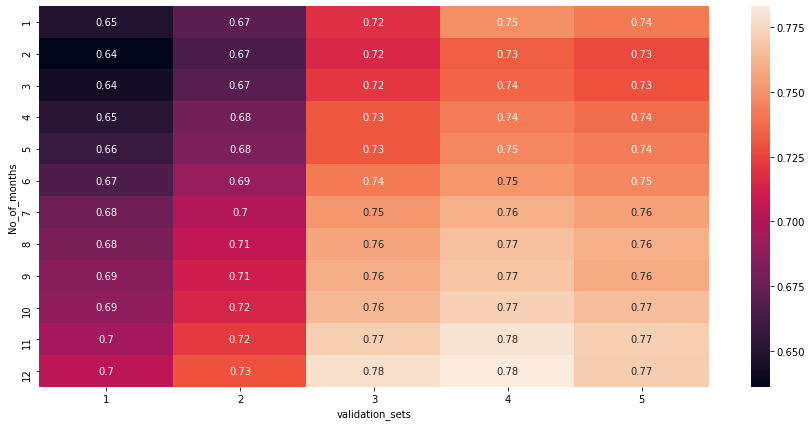

In [31]:
# correlation plot of the variables in the train data
plot = final_mean[final_mean.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [22]:
final_mean2, final_std2 = get_matrix(max_months=4,max_cv=15)

100%|██████████| 4/4 [01:14<00:00, 18.53s/it]


(4.0, 0.0)

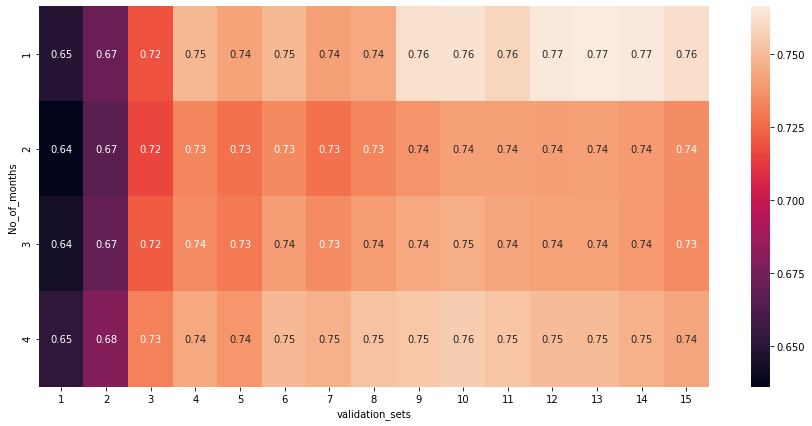

In [33]:
# correlation plot of the variables in the train data
final_mean2.columns = final_mean2.columns.droplevel()
plot = final_mean2[final_mean2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(4.0, 0.0)

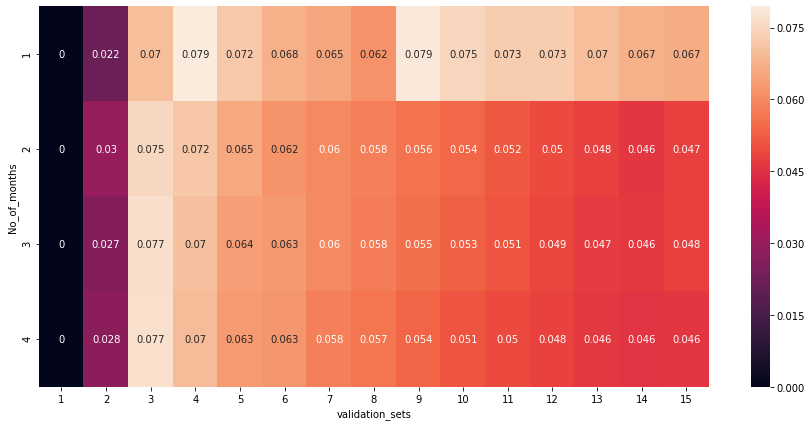

In [35]:
# correlation plot of the variables in the train data
final_std2.columns = final_std2.columns.droplevel()
plot = final_std2[final_std2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)